# CI-0115 Probabilidad y Estadística
## Prof. Sebastián Ruiz Blais
### I - 2024

### Proyecto: segunda entrega

#### Daniel Rojas Morales - C26836
#### José Pablo Mora Cubillo - B75044

---

# Bibliotecas utilizadas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from matplotlib.ticker import FuncFormatter
from math import sqrt

# Explicación de las columnas en las bases de datos de vinos:

1. **Fixed Acidity:** La cantidad total de ácidos (g/l) en el vino.
2. **Volatile Acidity:** La cantidad de ácidos volátiles (g/l) en el vino.
3. **Citric Acid:** La cantidad de ácido cítrico (g/l) en el vino.
4. **Residual Sugar:** La cantidad de azúcar residual (g/l) que queda después de la fermentación.
5. **Chlorides:** La cantidad de cloruros (g/l) en el vino.
6. **Free Sulfur Dioxide:** La cantidad de dióxido de azufre libre (mg/l) en el vino.
7. **Total Sulfur Dioxide:** La cantidad total de dióxido de azufre (mg/l) en el vino.
8. **Density:** La densidad del vino (g/cm³).
9. **pH:** El nivel de acidez o alcalinidad del vino, en una escala de 0 a 14.
10. **Sulphates:** La cantidad de sulfatos (g/l) en el vino.
11. **Alcohol:** El contenido de alcohol (% vol.) en el vino.
12. **Quality:** La calidad del vino, evaluada en una escala de 1 a 10.
13. **Wine Type:** El tipo de vino (blanco o rojo/tinto). 

# Cargar y manipular los datos utilizados

In [2]:
# cargar los datos
dataWhite = pd.read_csv('winequality-white.csv', sep=';')
dataRed = pd.read_csv('winequality-red.csv')

In [3]:
# Para los vinos rojos, agregamos una nueva columna llamada `data_type` y a todas las observaciones le asignamos como valor `Red`
dataRed['wine_type'] = "Red"

# Para los vinos blanco, agregamos una nueva columna llamada `data_type` y a todas las observaciones le asignamos como valor `White`
dataWhite['wine_type'] = "White"

# Se realiza la concatenación
dataWine = pd.concat([dataRed, dataWhite], axis = 0) # `axis=0` indica que se debe concatenar verticalmente
dataWine.reset_index(drop=True, inplace=True) # resetear los índices

In [4]:
# Renombrar variables de interes para la base de datos de vinos
dataWine = dataWine.rename(columns={'fixed acidity' : 'fixed_acidity',
                                    'citric acid' : 'citric_acid',
                                    'residual sugar' : 'residual_sugar',
                                    'free sulfur dioxide' : 'free_SO2',
                                    'total sulfur dioxide' : 'total_SO2',
                                    'volatile acidity' : 'volatile_acidity'})

In [5]:
# Excluir outliers (considerados en entrega anterior los que estaban +/- 3 veces el IQR)

# Almacenamos el nombre de columnas en una lista, excluimos las últimas dos
columns = dataWine.iloc[:,:11].columns.tolist() # castear objeto de tipo ` pandas.core.indexes.base.Index` a una lista

nrows_before = dataWine.shape[0]
# Los datos se almacen en un diccionario separando por tipo de vinp
quantileDic = {
  "Red":[],
  "White":[]
}

for i in range(dataWine.shape[1] - 2):
    for name in quantileDic:
        # Calcular primer cuartil, tercer cuartil y IQR
        Q1 = dataWine[dataWine["wine_type"] == name][columns[i]].quantile(0.25)
        Q3 = dataWine[dataWine["wine_type"] == name][columns[i]].quantile(0.75)
        quantileDic[name].append([Q1, Q3, Q3 - Q1])
        


for i in range(dataWine.shape[1] - 2): # excluir ultimas dos columnas
    for name in quantileDic:
        dataWine.reset_index(drop=True, inplace=True) # resetear los índices, de lo contrarío se presenta un error
        lower = quantileDic[name][i][0] - 3*quantileDic[name][i][2] # Q1 - 3*IQR
        upper = quantileDic[name][i][1] + 3*quantileDic[name][i][2] # Q3 - 3*IQR
        # Crear un array que contenga las filas donde se superó el límite superior o inferior 
        upper_list = np.where((dataWine[columns[i]] >= upper) & (dataWine["wine_type"] == name))[0]
        lower_list = np.where((dataWine[columns[i]] <= lower) & (dataWine["wine_type"] == name))[0]
        
        
        # Eliminar los outliers
        dataWine.drop(index=upper_list, inplace=True)
        dataWine.drop(index=lower_list, inplace=True)

In [6]:
# Visualizar el resultado de las manipulaciones realizadas:
dataWine

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_SO2,total_SO2,density,pH,sulphates,alcohol,quality,wine_type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,Red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,Red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,Red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,Red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,Red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6117,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,White
6118,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,White
6119,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,White
6120,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,White


# (1)

Inclusión de un tercer `DataFrame` llamado `dataComp`

In [7]:
dataComp = pd.read_csv('composition-wine.csv')

Primeras filas de `dataComp`:

In [8]:
dataComp.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline,Class
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


La nueva base de datos aporta nuevas variables que ayudarán a responder las preguntas planteadas anteriormente. Esta base de datos puede ser unida a `dataWine` por medio de la variable `Alcohol` asociando el porcentaje promedio de cada vino con las variables de `dataComp`, sin embargo, se tomatará solamente como referencia y se trabajarán de manera separada. De necesitar unificar ambos se utilizaría el siguiente códgio:

_Nota: Además de la nueva base de datos, anteriormente se unieron las bases de datos de `dataWhite` y `dataRed` en `dataWine`, cumpliendo con la especificación 1 de la segunda entrega._

In [9]:
# Fusionar los DataFrames basado en la columna 'Alcohol'
# merged_data = pd.merge(dataWine, dataComp, left_on = 'alcohol', right_on='Alcohol', how='inner')

# (2)

Preguntas que comparten categoría:

1. ¿Cuáles son las diferencias en las propiedades fisicoquímicas entre los vinos blancos y los vinos tintos en términos de acidez fija y pH?
2. ¿Cuál es el efecto de la acidez volátil y los azúcares residuales sobre la calidad del vino, categorizada como baja, media, alta?
3. ¿Es posible predecir el tipo de vino (blanco o tinto) basándose en las propiedades fisicoquímicas del pH y la acidez fija?

Preguntas que combinan variables:

4. ¿Es posible predecir la calidad del vino basándose en la acidez fija y la densidad?
5. ¿Cuáles variables fisicoquímicas, como el pH y los sulfitos (SO2 libre), tienen mayor impacto en la calidad del vino, diferenciando entre alta calidad y baja calidad?


# (3)

## Gráficas de Dispersión de las variables según la calidad

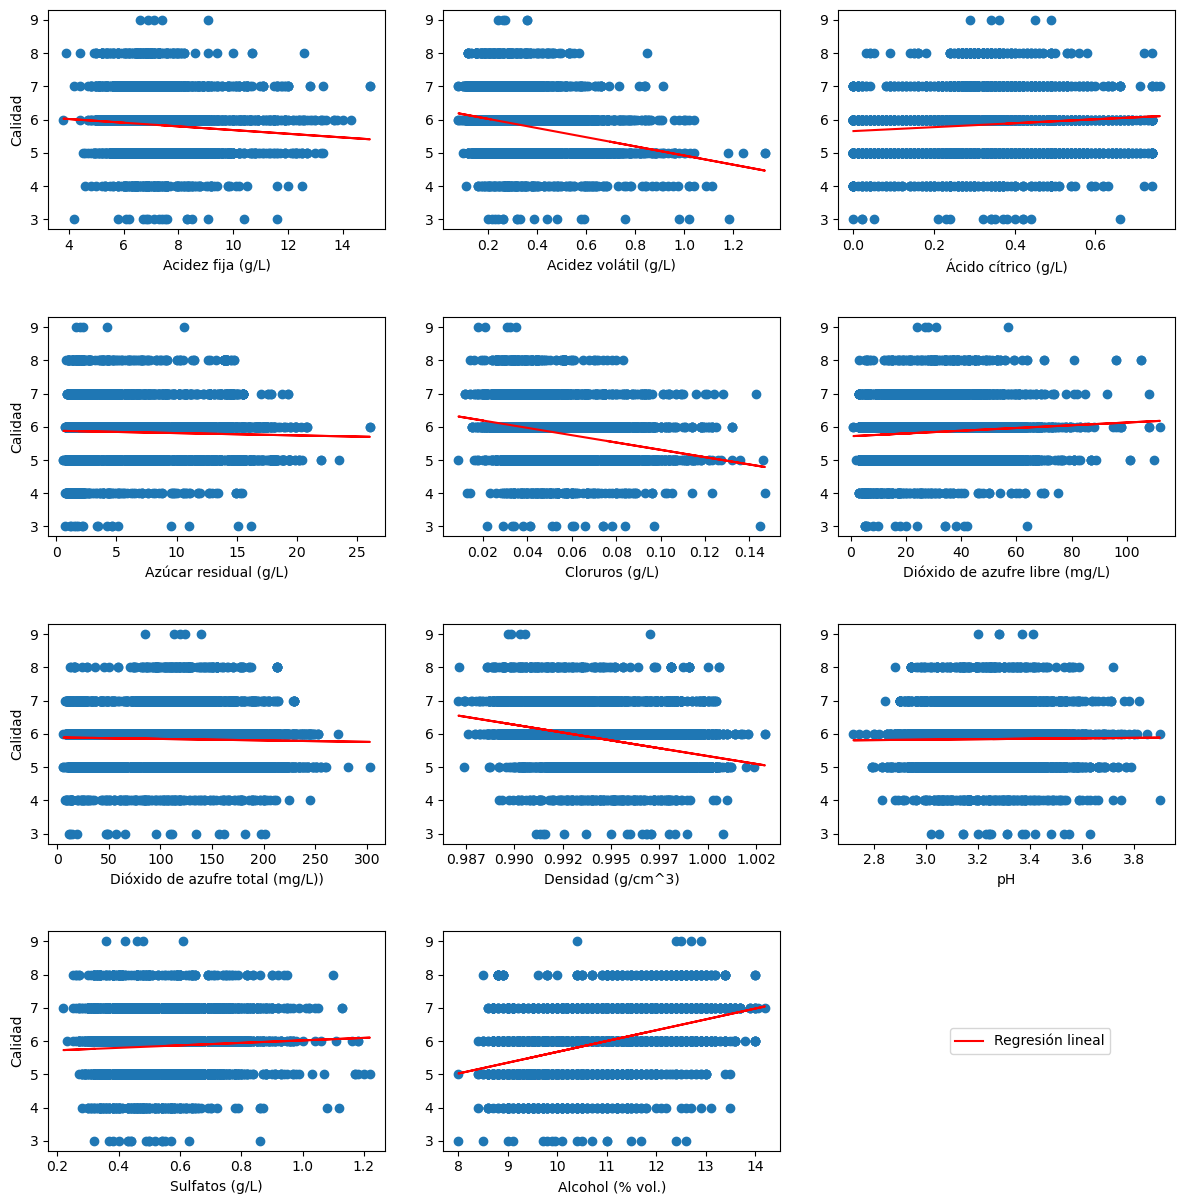

In [10]:
# guardamos el nombre de las etiquetas de los ejes Y y X
ylabel = "Calidad"
xlabels = ["Acidez fija (g/L)", "Acidez volátil (g/L)", "Ácido cítrico (g/L)", 
           "Azúcar residual (g/L)", "Cloruros (g/L)", "Dióxido de azufre libre (mg/L)",
          "Dióxido de azufre total (mg/L))", "Densidad (g/cm^3)", "pH",
          "Sulfatos (g/L)", "Alcohol (% vol.)"]

# Función formateadora para dos decimales
formatter = FuncFormatter(lambda x, _: f'{x:.3f}')

fig, pos = plt.subplots(4, 3, figsize=(12, 12))  # 4 filas y 3 columnas
fig.tight_layout()  # para separar los gráficos
fig.subplots_adjust(hspace=0.4)  # aumentar el espacio entre filas


for i, col_name in enumerate(columns): # De manera que i es el indice y col_name valor de la lista
    # Usamos lógica modular para calcular el valor de las filas y las columnas
    row_i = i // 3
    col_i = i % 3
    # Crear los gráficos de dispersión
    pos[row_i][col_i].scatter(dataWine[columns[i]], dataWine["quality"])
    
    # Poner etiqueta del eje x
    pos[row_i][col_i].set_xlabel(xlabels[i])
    
    # Únicamente ponemos el nombre de la etiqueta del eje y una vez por fila
    if col_i == 0:
        pos[row_i][col_i].set_ylabel(ylabel)
        
    # Se agrega la línea que mejor ajusta los datos
    m, b = np.polyfit(dataWine[columns[i]], dataWine["quality"], 1) # se le indica que ajuste 
                                                                    # para un polinomio de grado 1 
    # Se calcula la recta
    line = m * dataWine[columns[i]] + b
    
    # Agregar la recta al subplot
    # Este condicional es la forma más facil encontrada para evitar que la leyenda se repita
    if i == 0:
        pos[row_i][col_i].plot(dataWine[columns[i]], line, color='red', label='Regresión lineal')
    else:
         pos[row_i][col_i].plot(dataWine[columns[i]], line, color='red')
    
    if xlabels[i] == "Densidad (g/cm^3)":
        # Configurar el formateador para mostrar 3 decimales
        pos[row_i][col_i].xaxis.set_major_formatter(formatter)
        
    
pos[3][2].axis('off') # para evitar que se muestre el subplot vacío que está en la posición [3][2]
fig.legend(bbox_to_anchor = (0.93, 0.14)) # `bbox_to_anchor` para mover la leyenda 

plt.show()

****1. Acidez fija (g/L) vs Calidad:****

Distribución: Los puntos están dispersos a lo largo del eje de acidez fija, aunque se observa una mayor concentración de datos en el rango de 6 a 9 g/L.
Tendencia: La línea de tendencia (roja) muestra una ligera pendiente negativa, indicando que a mayor acidez fija, la calidad tiende a disminuir ligeramente.

****2. Acidez volátil (g/L) vs Calidad:****

Distribución: Los datos están bastante dispersos en el rango de 0.1 a 0.6 g/L, con una mayor concentración alrededor de 0.3 g/L.
Tendencia: La línea de tendencia también muestra una pendiente negativa, sugiriendo que una mayor acidez volátil se asocia con una menor calidad.

****3. Ácido cítrico (g/L) vs Calidad:****

Distribución: Los puntos están concentrados principalmente en el rango de 0 a 0.75 g/L.
Tendencia: La línea de tendencia tiene una pendiente positiva, lo que indica que cantidades mayores de ácido cítrico tienden a estar asociadas con calidades mayores.

****4. Azúcar residual (g/L) vs Calidad:****

Distribución: Los datos están dispersos ampliamente, pero se concentran en los rangos de 0 a 10 g/L y en menor medida hasta 30 g/L, con algunos valores atípicos llegando hasta 60 g/L.
Tendencia: La línea de tendencia muestra una leve pendiente negativa, sugiriendo una ligera disminución en la calidad con un aumento en el azúcar residual.

****5. Cloruros (g/L) vs Calidad:****

Distribución: Los puntos están dispersos principalmente en el rango de 0 a 0.2 g/L, con una menor calidad de datos en rangos mayores hasta 0.6 g/L.
Tendencia: La línea de tendencia es negativa, indicando que mayores niveles de cloruros tienden a asociarse con calidades menores.

****6. Dióxido de azufre libre (mg/L) vs Calidad:****

Distribución: Los datos están dispersos a lo largo de todo el rango hasta 300 mg/L, con una mayor concentración en los primeros 50 mg/L.
Tendencia: La línea de tendencia muestra una pendiente positiva, sugiriendo que mayores niveles de dióxido de azufre libre se asocian con mayores calidades.

****7. Dióxido de azufre total (mg/L) vs Calidad:****

Distribución: Los puntos están bastante dispersos a lo largo del eje de dióxido de azufre total, con una mayor concentración de datos en el rango de 0 a 200 mg/L.
Tendencia: La línea de tendencia (roja) es casi horizontal, indicando que no hay una relación significativa entre el dióxido de azufre total y la calidad.

****8. Densidad (g/cm³) vs Calidad:****

Distribución: Los datos están concentrados principalmente en el rango de 0.99 a 1.00 g/cm³, con algunos valores atípicos en rangos mayores.
Tendencia: La línea de tendencia muestra una pendiente negativa pronunciada, sugiriendo que una mayor densidad se asocia con una menor calidad.

****9. pH vs Calidad:****

Distribución: Los puntos están dispersos principalmente en el rango de pH de 3.0 a 3.6, con algunas concentraciones más altas alrededor de 3.3 a 3.4.
Tendencia: La línea de tendencia es casi horizontal, indicando que no hay una relación significativa entre el pH y la calidad.

****10. Sulfatos (g/L) vs Calidad:****

Distribución: Los datos están dispersos en el rango de 0.25 a 1.25 g/L, con algunas concentraciones más altas alrededor de 0.5 a 0.75 g/L.
Tendencia: La línea de tendencia muestra una ligera pendiente positiva, indicando que una mayor cantidad de sulfatos tiende a asociarse con una mayor calidad.

****11. Alcohol (% vol.) vs Calidad:****

Distribución: Los puntos están dispersos a lo largo del eje de alcohol, con una mayor concentración de datos en el rango de 9 a 12 % vol.
Tendencia: La línea de tendencia tiene una pendiente positiva, lo que indica que una mayor cantidad de alcohol tiende a estar asociada con una mayor calidad.

## Gráficos de cajas

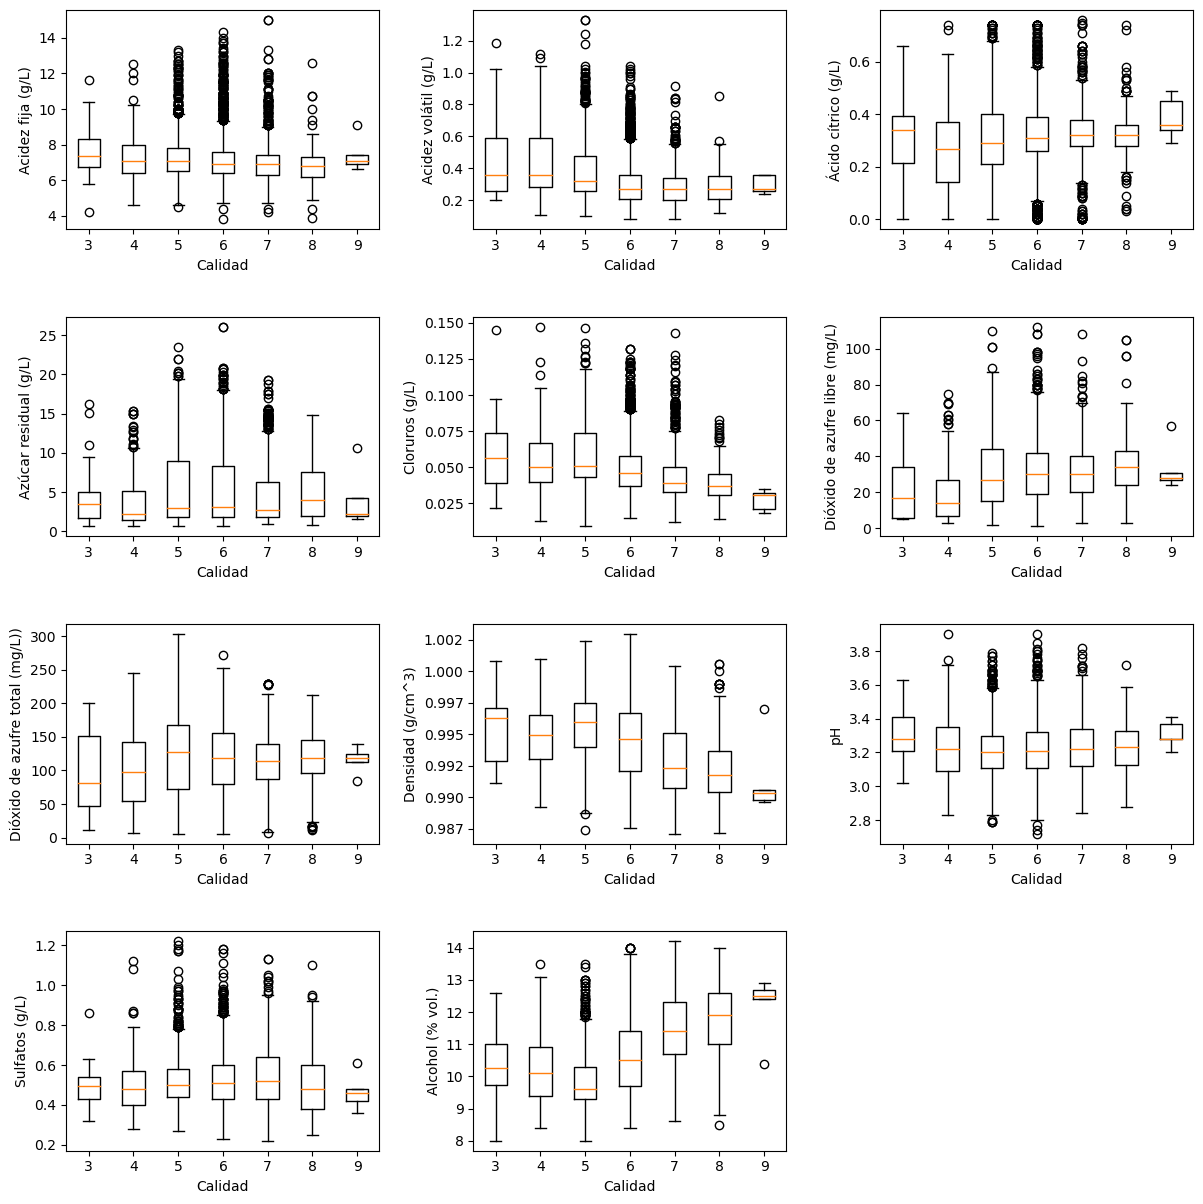

In [11]:
fig, pos = plt.subplots(4, 3, figsize=(12, 12))  # 4 filas y 3 columnas
fig.tight_layout()  # para separar los gráficos
fig.subplots_adjust(hspace = 0.4, wspace = 0.3)  # aumentar el espacio entre filas y columnas

for i, col_name in enumerate(columns): # De manera que i es el indice y col_name valor de la lista
    # Usamos lógica modular para calcular el valor de las filas y las columnas
    row_i = i // 3
    col_i = i % 3
    
    # Crear los diagramas de cajas
    pos[row_i][col_i].boxplot(
        [dataWine[dataWine["quality"] == q][col_name] for q in sorted(dataWine["quality"].unique())],
        labels=sorted(dataWine["quality"].unique())
    )
    
    # Poner etiqueta del eje x
    pos[row_i][col_i].set_xlabel(ylabel)
    #Poner etiqueta en el eje y
    pos[row_i][col_i].set_ylabel(xlabels[i])
    
    if xlabels[i] == "Densidad (g/cm^3)":
        # Configurar el formateador para mostrar 3 decimales
        pos[row_i][col_i].yaxis.set_major_formatter(formatter)
    
    # Poner título para cada subplot
    #pos[row_i][col_i].set_title(f'{col_name} vs quality')
    
# Desactivar el subplot vacío en la posición [3][2]
pos[3][2].axis('off')

plt.show()

De los gráficos anteriores se tiene sobre las cuatro variables más significativas son:

****1. Ácido volátil vs calidad:****

Se observa una disminución general en la mediana del ácido volátil a medida que la calidad del vino aumenta. Los vinos con menor ácido volátil tienden a tener una mejor calidad. Esto sugiere que altos niveles de ácido volátil pueden estar asociados con sabores indeseables como el olor a vinagre, lo que impacta negativamente en la percepción de calidad del vino.

****2. Cloruros vs calidad:****

Existe una tendencia decreciente en la mediana de cloruros conforme aumenta la calidad. La concentración de cloruros, que pueden indicar salinidad, tiende a ser menor en vinos de mayor calidad. Altos niveles de cloruros pueden influir negativamente en el sabor y, por lo tanto, en la percepción de la calidad.

****3. Densidad vs calidad:****

Se aprecia que la densidad disminuye ligeramente a medida que la calidad aumenta, especialmente en los vinos de calidad más alta (8 y 9). La densidad puede estar relacionada con la cantidad de azúcares y alcohol en el vino. Vinos con menor densidad podrían tener menos azúcares residuales y una composición equilibrada, asociada a una mejor calidad.

****4. Alcohol vs calidad:****

La mediana del contenido de alcohol tiende a aumentar con la calidad del vino. Un mayor contenido de alcohol generalmente está asociado con una mayor calidad del vino, posiblemente porque contribuye a un mejor equilibrio y complejidad de sabores. Los vinos con más alcohol suelen tener un perfil más robusto y completo, lo que puede ser valorado positivamente.

# (4)

## Regresión Lineal

Utilizando la regresión líneal se busca responder las siguientes preguntas:
    
1. ¿En qué medida la acidez fija y la acidez volátil pueden predecir la acidez total del vino?
2. ¿Qué tan eficazmente pueden el pH y la densidad predecir el contenido de alcohol en el vino?
3. ¿Hasta qué punto los niveles de cloruros y azúcares residuales pueden predecir la densidad del vino?

# (5)

Utilizando la regresión líneal se busca responder las siguientes preguntas:
    
1. ¿En qué medida la acidez fija y la acidez volátil pueden predecir la concentración de ácido cítrico del vino?
2. ¿Qué tan eficazmente pueden el pH y la densidad predecir el contenido de alcohol en el vino?
3. ¿Hasta qué punto los niveles de cloruros y azúcares residuales pueden predecir la densidad del vino?

In [12]:
# Función para preparar las matrices con NumPy
def prepare_matrices(data, independent_vars, dependent_var):
    # Añadir una columna de unos para el término independiente
    X = np.ones((data.shape[0], len(independent_vars) + 1))
    X[:, 1:] = data[independent_vars].values
    y = data[dependent_var].values.reshape(-1, 1)
    return X, y

# Función para realizar la regresión lineal usando NumPy
def linear_regression(X, y):
    Xt = X.T
    XtX = np.dot(Xt, X)
    XtX_inv = np.linalg.inv(XtX)
    Xty = np.dot(Xt, y)
    coefficients = np.dot(XtX_inv, Xty)
    return coefficients

# Pregunta 1: Predicción de ácido cítrico
independent_vars1 = ['fixed_acidity', 'volatile_acidity']
dependent_var1 = 'citric_acid'
X1, y1 = prepare_matrices(dataWine, independent_vars1, dependent_var1)
coefficients1 = linear_regression(X1, y1)
print("Coeficientes para predecir la acidez total:", coefficients1)

# Pregunta 2: Predicción del contenido de alcohol
independent_vars2 = ['pH', 'density']
dependent_var2 = 'alcohol'
X2, y2 = prepare_matrices(dataWine, independent_vars2, dependent_var2)
coefficients2 = linear_regression(X2, y2)
print("Coeficientes para predecir el contenido de alcohol:", coefficients2)

# Pregunta 3: Predicción de la densidad del vino
independent_vars3 = ['chlorides', 'residual_sugar']
dependent_var3 = 'density'
X3, y3 = prepare_matrices(dataWine, independent_vars3, dependent_var3)
coefficients3 = linear_regression(X3, y3)
print("Coeficientes para predecir la densidad del vino:", coefficients3)

Coeficientes para predecir la acidez total: [[ 0.11767726]
 [ 0.04769513]
 [-0.44012611]]
Coeficientes para predecir el contenido de alcohol: [[ 301.96346419]
 [   0.90107657]
 [-295.94806311]]
Coeficientes para predecir la densidad del vino: [[9.87393174e-01]
 [9.73935664e-02]
 [4.05573157e-04]]


## Respondiendo las preguntas planteadas

### Pregunta 1: Predicción del ácido cítrico del vino

**Variables independientes:** `fixed_acidity`, `volatile_acidity`  
**Variable dependiente:** `citric_acid`

Los coeficientes obtenidos son:
- Intercepto: 0.11767726
- Coeficiente para `fixed_acidity`: 0.04769513
- Coeficiente para `volatile_acidity`: -0.44012611

Esto significa que la ecuación de regresión lineal para predecir la `citric_acid` (acidez total) sería:

`citric_acid = 0.11767726 + 0.04769513 × fixed_acidity − 0.44012611 × volatile_acidity`

- **Intercepto:** El valor inicial esperado de `citric_acid` cuando `fixed_acidity` y `volatile_acidity` son cero.
- **Coeficiente de `fixed_acidity`:** Por cada unidad que aumenta `fixed_acidity`, se espera que `citric_acid` aumente en 0.04769513 unidades, manteniendo constante `volatile_acidity`.
- **Coeficiente de `volatile_acidity`:** Por cada unidad que aumenta `volatile_acidity`, se espera que `citric_acid` disminuya en 0.44012611 unidades, manteniendo constante `fixed_acidity`.

Por lo tanto, la acidez fija (`fixed_acidity`) y la acidez volátil (`volatile_acidity`) pueden predecir la acidez total (`citric_acid`) del vino en función de cómo varían estos dos componentes.

<u>Sección 6:
- Error estandar: 0.1101
- Coeficiente de determinación múltiple: 0.35248
- coeficiente ajustado de determinació múltiple:0.35227 


### Pregunta 2: Predicción del contenido de alcohol

**Variables independientes:** `pH`, `density`  
**Variable dependiente:** `alcohol`

Los coeficientes obtenidos son:
- Intercepto: 301.96346499
- Coeficiente para `pH`: 0.90107657
- Coeficiente para `density`: -295.94806392

La ecuación de regresión lineal para predecir el `alcohol` basado en `pH` y `density` sería:

`alcohol = 301.96346499 + 0.90107657 × pH − 295.94806392 × density`

- **Intercepto:** El valor inicial esperado de `alcohol` cuando `pH` y `density` son cero.
- **Coeficiente de `pH`:** Por cada unidad que aumenta `pH`, se espera que el contenido de `alcohol` aumente en 0.90107657 unidades, manteniendo constante `density`.
- **Coeficiente de `density`:** Por cada unidad que aumenta `density`, se espera que el contenido de `alcohol` disminuya en 295.94806392 unidades, manteniendo constante `pH`.

Esto sugiere que `pH` y `density` pueden predecir el contenido de alcohol en el vino, aunque el efecto de `density` es más pronunciado en la predicción.

<u>Sección 6:
- Error estandar: 0.80997
- Coeficiente de determinación múltiple: 0.537666 
- coeficiente ajustado de determinació múltiple: 0.53751

### Pregunta 3: Predicción de la densidad del vino

**Variables independientes:** `chlorides`, `residual_sugar`  
**Variable dependiente:** `density`

Los coeficientes obtenidos son:
- Intercepto: 0.987393174
- Coeficiente para `chlorides`: 0.0973935664
- Coeficiente para `residual_sugar`: 0.000405573157

La ecuación de regresión lineal para predecir `density` en función de `chlorides` y `residual_sugar` es:

`density = 0.987393174 + 0.0973935664 × chlorides + 0.000405573157 × residual_sugar`

- **Intercepto:** El valor inicial esperado de `density` cuando `chlorides` y `residual_sugar` son cero.
- **Coeficiente de `chlorides`:** Por cada unidad que aumenta `chlorides`, se espera que `density` aumente en 0.0973935664 unidades, manteniendo constante `residual_sugar`.
- **Coeficiente de `residual_sugar`:** Por cada unidad que aumenta `residual_sugar`, se espera que `density` aumente en 0.000405573157 unidades, manteniendo constante `chlorides`.

Por lo tanto, los niveles de `chlorides` y `residual_sugar` pueden predecir la densidad del vino, aunque el efecto de `chlorides` es más significativo en la predicción de la densidad.

<u>Sección 6:
- Error estandar: 0.001547
- Coeficiente de determinación múltiple: 0.71909
- coeficiente ajustado de determinació múltiple: 0.7189989 

# (6)

### Error estándar de la estimación multiple:

$$SE = \sqrt{\frac{SCE}{n - (k+1)}}$$

Donde `n` es el número de observaciones, `k` el número de variables independientes y `SCE` la suma de cuadrados del error. Indica cuánto se alejan en promedio las estimaciones con respecto de los valores reales. 

In [13]:
# Función que calcula el valor estimado con base en los coeficientes y el valor estimado
def getEstimate(dataFrame, independent_vars, coefficients):
    # El primer valor es el intercepto
    estimates = pd.Series([coefficients[0]]*len(dataFrame))
    
    # Sumar los productos de los coeficientes y las variables independientes
    for i in range(len(independent_vars)):
        estimates += coefficients[i + 1] * dataFrame[independent_vars[i]]
        
    return estimates

In [14]:
def getStandardError(dataFrame, independent_vars, dependet_var, coefficients):
    # Obtenemos el valor estimado con base en la regresión lineal múltiple 
    estimates =  getEstimate(dataFrame, independent_vars, coefficients)
    # Calculamos el error
    error = dataFrame[dependet_var] - estimates
    # Calculamos la suma de cuadrados del error
    sce = np.sum(error ** 2)
    # Aplicamos la formula:
    return sqrt((sce/(len(dataFrame)-(len(independent_vars)+1)))[0])

In [15]:
# Error estándar de la estimación multiple para la pregunta 1 [Predicción de ácido cítrico]
getStandardError(dataWine, ['fixed_acidity', 'volatile_acidity'], 'citric_acid',  coefficients1)

0.11007399089876505

In [16]:
# Error estándar de la estimación multiple para la pregunta 2 [Predicción del contenido de alcohol]
getStandardError(dataWine,  ['pH', 'density'], 'alcohol',  coefficients2)

0.8099718236869259

In [17]:
# Error estándar de la estimación multiple para la pregunta 3 [Predicción de la densidad del vino]
getStandardError(dataWine, ['chlorides', 'residual_sugar'], 'density',  coefficients3)

0.001547460810557781

### Coeficiente de determinación múltiple (R^2)

Indica el porcentaje de la variación de la variable dependiente explicada por el conjunto de las variables independientes.

$$R^2 = \frac{SCR}{STC}$$

Donde `SCR` es la suma de cuadrados de la regresión y `STC` es la suma total de cuadrados. Toma valores entre 0 y 1. Puede aumentar al agregar más variables independientes, sin que esto signifique que la nueva variable sea un buen factor de predicción. 

In [18]:
#Función que cálcula el coeficiente de determinación múltiple
def getCoefDeter(dataFrame, independent_vars, dependet_var, coefficients):
    # Obtenemos el valor estimado con base en la regresión lineal múltiple 
    estimates =  getEstimate(dataFrame, independent_vars, coefficients)
    mean = dataWine[dependet_var].mean()
    
    # Calculamos la resta del estimado con el promedio
    subtractionResult =  estimates - mean
    # Calculamos la suma de cuadrados de la regresión 
    scr = np.sum(subtractionResult ** 2)
    
    # Calculamos la suma de cuadrados del error 
    error = dataFrame[dependet_var] - estimates
    # Calculamos la suma de cuadrados del error
    sce = np.sum(error ** 2)
    
    sct = scr + sce
    return (scr/sct)[0]

In [19]:
# R^2 para la pregunta 1 [Predicción de ácido cítrico]
getCoefDeter(dataWine, ['fixed_acidity', 'volatile_acidity'], 'citric_acid',  coefficients1)

0.35247678882146566

In [20]:
# R^2 para la pregunta 2 [Predicción del contenido de alcohol]
getCoefDeter(dataWine,  ['pH', 'density'], 'alcohol',  coefficients2)

0.5376660172149863

In [21]:
# R^2 para la pregunta 3 [Predicción de la densidad del vino]
getCoefDeter(dataWine, ['chlorides', 'residual_sugar'], 'density',  coefficients3)

0.7190907697380596

### Coeficiente ajustado de determinación múltiple

Coeficiente de determinación múltiple ajustado para considerar el número de variables y el tamaño de la muestra

$$R^2 ajust = 1 - (1-R^2) \frac{n-1}{n-k-1}$$

Donde `k` es el número de variables independientes y n el número de observaciones.

In [22]:
#Función que cálcula el coeficiente de determinación múltiple
def getCoefDeterAjust(dataFrame, independent_vars, dependet_var, coefficients):
    r2 = getCoefDeter(dataFrame, independent_vars, dependet_var, coefficients)
    n = len(dataFrame)
    k = len(independent_vars)
    result = (1 - r2)*((n-1)/(n-k-1))
    return (1 - result)

In [23]:
# R^2 ajustado para la pregunta 1 [Predicción de ácido cítrico]
getCoefDeterAjust(dataWine, ['fixed_acidity', 'volatile_acidity'], 'citric_acid',  coefficients1)

0.35226514534665665

In [24]:
# R^2 ajustado para la pregunta 2 [Predicción del contenido de alcohol]
getCoefDeterAjust(dataWine,  ['pH', 'density'], 'alcohol',  coefficients2)

0.537514902986261

In [25]:
# R^2 para la pregunta 3 [Predicción de la densidad del vino]
getCoefDeterAjust(dataWine, ['chlorides', 'residual_sugar'], 'density',  coefficients3)

0.7189989543334963

# (7)

Para este ejercicio vamos a usar el tercer modelo:  
`density = 0.987393174 + 0.0973935664 × chlorides + 0.000405573157 × residual_sugar`

In [26]:
# Creamos una función que simula el modelo
def predictDensity(chlorides_value, residual_sugar_value):
    return (0.987393174 + 0.0973935664*chlorides_value + 0.000405573157*residual_sugar_value)

Para generar los 3 valores, se va a considerar los cuartiles de las variables `chlorides` y `residual_sugar`

In [27]:
chlorides_values = dataWine["chlorides"].quantile([0.25, 0.50, 0.75]).reset_index(drop=True)
chlorides_values

0    0.037
1    0.046
2    0.060
Name: chlorides, dtype: float64

In [28]:
residual_sugar_values =  dataWine["residual_sugar"].quantile([0.25, 0.50, 0.75]).reset_index(drop=True)
residual_sugar_values
# Notar que cada fila se va a usar para una predicción, por ejemplo, los valores chlorides_values[0] y residual_sugar_values[0]
# se van a usar para la primera predicción. 

0    1.8
1    2.9
2    8.1
Name: residual_sugar, dtype: float64

In [30]:
# Generamos la predicción de densidad
predictDensity(chlorides_values, residual_sugar_values) # devuelve las tres densidades predecidas

0    0.991727
1    0.993049
2    0.996522
dtype: float64

Para determinar si las predicciones son valiosas, decidimos comparar los valores predichos contra valores reales que se encuentren cerca de los valores de las variables independientes usadas para generar la predicción. En este caso, se tomó los datos del DF que se encuentra a +/- 5% los valores de `residual_sugar` y `chlorides` usados en la predicción. Para los 3 casos, se encontró que los valores predichos se encuentran dentro del rango de los valores obtenidos usando +/- 5% los valores de las variables independientes, esto nos estaría indicando que el modelo cuenta con una capacidad predictiva valiosa.  
Es importante mencionar que, entre los rangos obtenidos usando +/- 5% los valores de las variables independientes, se encontró cierto traslape. Pero como se muestra con los valores máximos y mínimos, los valores de las variables aumentan entre los grupos (grupo 3 > grupo 2 > grupo 1). Esto concuerda con nuestro modelo,  que predice que un aumento en las variables `chlorides` y `residual_sugar` resulta en un aumento de la densidad. 


In [31]:
# Grupo 1
# mínimo: 0.98819
# máximo: 0.99269
dataWine[(dataWine["residual_sugar"] > residual_sugar_values[0] * 0.95) &
         (dataWine["residual_sugar"] < residual_sugar_values[0] * 1.05) &
        (dataWine["chlorides"] > chlorides_values[0] * 0.95) &
         (dataWine["chlorides"] < chlorides_values[0] * 1.05)]["density"]

2639    0.99110
2927    0.99120
3409    0.99250
3863    0.99269
4767    0.99130
4780    0.99130
4806    0.98819
5754    0.99000
Name: density, dtype: float64

In [32]:
# Grupo 2
# mínimo: 0.98896
# máximo: 0.0.9942
dataWine[(dataWine["residual_sugar"] > residual_sugar_values[1] * 0.95) &
         (dataWine["residual_sugar"] < residual_sugar_values[1] * 1.05) &
        (dataWine["chlorides"] > chlorides_values[1] * 0.95) &
         (dataWine["chlorides"] < chlorides_values[1] * 1.05)]["density"]

1557    0.99240
2324    0.99360
2977    0.99420
4578    0.99130
4579    0.99126
4580    0.99130
4583    0.98896
4593    0.98896
5657    0.99043
5702    0.99304
5760    0.99040
Name: density, dtype: float64

In [33]:
# Grupo 3
# mínimo: 0.99257
# máximo: 0.9972
dataWine[(dataWine["residual_sugar"] > residual_sugar_values[2] * 0.95) &
         (dataWine["residual_sugar"] < residual_sugar_values[2] * 1.05) &
        (dataWine["chlorides"] > chlorides_values[2] * 0.95) &
         (dataWine["chlorides"] < chlorides_values[2] * 1.05)]["density"]

1438    0.99560
1439    0.99560
2059    0.99610
2137    0.99540
3028    0.99660
3202    0.99720
3653    0.99660
3909    0.99615
5150    0.99545
5332    0.99257
5333    0.99506
5334    0.99257
5356    0.99425
5360    0.99425
Name: density, dtype: float64

# (8)

Para esta sección, se agregará una variable extra a cada uno de los modelos. La variable se decidió con base en la matriz de correlación (dataWine.corr()). Se agregó la variable con mayor correlación y que no formaba parte del modelo. 

**Criterio para considerar que un modelo es mejor:** se considera que los modelos con menor error estándar y mayor R^2 ajustado son mejores. Esto debido a que un menor error muestra que las predicciones están más cerca de los valores reales, mientras que un mayor R^2 ajustado significa que el modelo es más robusto y explica de mejor manera la variación de los datos.

### Pregunta 1: Predicción del ácido cítrico del vino

**Variables independientes:** `fixed_acidity`, `volatile_acidity`, `pH` (nueva variable agregada)  
**Variable dependiente:** `citric_acid`


La nueva ecuación de regresión lineal para predecir `citric_acid` basado en `fixed_acidity`, `volatile_acidity` y `pH` sería:

`citric_acid = 0.37488604 + 0.04461017 × fixed_acidity − 0.41383751 × volatile_acidity - 0.07568202 x pH`

<u>Modulo actual:  
- Error estándar:  0.109532286790005
- Coeficiente ajustado de determinación múltiple:  0.3586248174122799
    
<u>Modelo anterior:
- Error estandar: 0.1101
- coeficiente ajustado de determinació múltiple: 0.35227 

**Conclusión:** el nuevo modelo presenta un menor error estándar y un mayor coeficiente ajustado de determinación múltiple, por lo que el nuevo modelo es ligeramente mejor. Sin embargo, debido a que este cambio es pequeño, no se puede concluir que la nueva variable agregada sea un buen predictor.
    
### Pregunta 2: Predicción del contenido de alcohol

**Variables independientes:** `pH`, `density`, `residual_sugar` (nueva variable agregada)  
**Variable dependiente:** `alcohol`

La nueva ecuación de regresión lineal para predecir el `alcohol` basado en `pH`, `density` y `residual_sugar` sería:

`alcohol = 3.17247649e+02 + 0.1.05981125 × pH − 3.11927913e+02 × density + 1.80673174e-02 x residual_sugar`  

<u>Modulo actual:  
- Error estándar:  0.807270105064018
- Coeficiente ajustado de determinación múltiple:  0.5405950610733645

<u>Modelo anterior:
- Error estandar: 0.80997
- coeficiente ajustado de determinació múltiple: 0.53751

**Conclusión:** el nuevo modelo presenta un menor error estándar y un mayor coeficiente ajustado de determinación múltiple, por lo que el nuevo modelo es ligeramente mejor. Sin embargo, debido a que este cambio es pequeño, no se puede concluir que la nueva variable agregada sea un buen predictor.
    
    
### Pregunta 3: Predicción de la densidad del vino

**Variables independientes:** `chlorides`, `residual_sugar`, `alcohol`  
**Variable dependiente:** `density`


La nueva ecuación de regresión lineal para predecir `density` en función de `chlorides`, `residual_sugar` y `alcohol` es:

`density = 9.98838226e-01 + 7.60741426e-02 × chlorides + 3.00079731e-04 × residual_sugar` + -9.29729387e-04 x `alcohol`

<u>Modulo actual:
- Error estándar de la estimación multiple:  0.001234
- Coeficiente ajustado de determinación múltiple:  0.8213

<u>Modelo anterior:
- Error estandar: 0.001547
- coeficiente ajustado de determinació múltiple: 0.7190 
    
**Conclusión:** el nuevo modelo presenta un menor error estándar y un mayor coeficiente ajustado de determinación múltiple, por lo que el nuevo modelo es mejor. Debido a que el aumento en el R^2 ajustado fue de más de 0.1, consideramos que la nueva variable es un buen predictor y debe ser incluida en el modelo.

In [34]:
# Pregunta 1: Predicción de ácido cítrico
independent_vars1 = ['fixed_acidity', 'volatile_acidity', 'pH'] # se agregó `ph`
dependent_var1 = 'citric_acid'
X1, y1 = prepare_matrices(dataWine, independent_vars1, dependent_var1)
coefficients1 = linear_regression(X1, y1)
print("> Coeficientes para predecir la acidez total:\n", coefficients1)
print("> Error estándar de la estimación multiple: ", getStandardError(dataWine, independent_vars1, dependent_var1,  coefficients1))
print("> Coeficiente ajustado de determinación múltiple: ", getCoefDeterAjust(dataWine, independent_vars1, dependent_var1,  coefficients1))

print("\n")

# Pregunta 2: Predicción del contenido de alcohol
independent_vars2 = ['pH', 'density', 'residual_sugar'] # se agregó `residual_sugar`
dependent_var2 = 'alcohol'
X2, y2 = prepare_matrices(dataWine, independent_vars2, dependent_var2)
coefficients2 = linear_regression(X2, y2)
print("Coeficientes para predecir el contenido de alcohol:\n", coefficients2)
print("> Error estándar de la estimación multiple: ", getStandardError(dataWine, independent_vars2, dependent_var2,  coefficients2))
print("> Coeficiente ajustado de determinación múltiple: ", getCoefDeterAjust(dataWine, independent_vars2, dependent_var2,  coefficients2))

print("\n")


# Pregunta 3: Predicción de la densidad del vino
independent_vars3 = ['chlorides', 'residual_sugar', 'alcohol'] # se agregó `alcohol`
dependent_var3 = 'density'
X3, y3 = prepare_matrices(dataWine, independent_vars3, dependent_var3)
coefficients3 = linear_regression(X3, y3)
print("Coeficientes para predecir la densidad del vino:\n", coefficients3)
print("> Error estándar de la estimación multiple: ", getStandardError(dataWine, independent_vars3, dependent_var3,  coefficients3))
print("> Coeficiente ajustado de determinación múltiple: ", getCoefDeterAjust(dataWine, independent_vars3, dependent_var3,  coefficients3))

print("\n")

> Coeficientes para predecir la acidez total:
 [[ 0.37488604]
 [ 0.04461017]
 [-0.41383751]
 [-0.07568202]]
> Error estándar de la estimación multiple:  0.109532286790005
> Coeficiente ajustado de determinación múltiple:  0.3586248174122799


Coeficientes para predecir el contenido de alcohol:
 [[ 3.17247649e+02]
 [ 1.05981125e+00]
 [-3.11927913e+02]
 [ 1.80673174e-02]]
> Error estándar de la estimación multiple:  0.807270105064018
> Coeficiente ajustado de determinación múltiple:  0.5405950610733645


Coeficientes para predecir la densidad del vino:
 [[ 9.98838226e-01]
 [ 7.60741426e-02]
 [ 3.00079731e-04]
 [-9.29729387e-04]]
> Error estándar de la estimación multiple:  0.0012340490825749747
> Coeficiente ajustado de determinación múltiple:  0.8212963247515505




# (9)

En la entrega 1, se obtuvo que las variables que presentaban una mayor correlación (coeficiente de correlación) con la calidad del vino fueron `alcohol` (0.447549) y `density` (0.318176). De igual manera, Se observó en los histogramas que ciertas variables presentan diferencias en sus distribuciones, siendo notables los casos de `volatile_acidity`, `chlorides` y `total_SO2`. Con base en lo anterior, se quiere responder las siguientes preguntas:  

<u>Diferencias utilizando las calidades como variable indepentiende (categorias):
 
 1) **¿Existen diferencias significativas entre las medias de los valores de `alcohol` para las diferentes calidades?**

**R:** *EL ANOVA indica que que existen diferencias significativas entre las diferentes categorías para las medias de `alcohol`. La prueba de Tukey reveló que existen diferencias significativas entre todas las categorías.*   

&nbsp;

 2) **¿Existen diferencias significativas entre las medias de los valores de `density` para las diferentes calidades?**   
 
**R:** *EL ANOVA indica que que existen diferencias significativas entre las diferentes categorías para las medias de `density`. La prueba de Tukey reveló que existen diferencias significativas entre todas las categorías, con excepción de entre los grupos 4 y 6, y 7 y 8.*

&nbsp;
 
 <u>Diferencias utilizando el tipo de vino (rojo o blanco) como variable indepentiende (categorias):  
 
 3) **¿Existen diferencias significativas entre las medias de los valores de `volatile_acidity` para los tipos de vino?**
 
 **R:** *EL ANOVA indica que que existen diferencias significativas entre ambos tipos de vino para las medias de `volatile_acidity`.* 
 
&nbsp;
 
 4) **¿Existen diferencias significativas entre las medias de los valores de `chlorides` para los tipos de vino?**
 
  **R:** *EL ANOVA indica que que existen diferencias significativas entre ambos tipos de vino para las medias de `chlorides`.*
 
&nbsp;
 
 5) **¿Existen diferencias significativas entre las medias de los valores de `total_SO2` para los tipos de vino?**
 
   **R:** *EL ANOVA indica que que existen diferencias significativas entre ambos tipos de vino para las medias de `total_SO2`.*
 
&nbsp;

<u>Conclusión</u>: Debido a los resultados anteriores, en todos los casos se podría decir que la media de los grupos para la variable analizada provienen de diferentes distribuciones. 
     

 **Nota:** *por simplicidad, las respuestas de la **pregunta 11** se respondieron en esta sección, **ver código** en sección de ANOVA.*  
 **Nota 2:** *en la entrega 3 se revizará la normalidad y homocedasticidad de las variables para determinar si estas conclusiones son adecuadas.*

Como se muestra a continuación, las calidades 3 y 9 presentan pocos datos. Por lo que se va a crear un nuevo `DataFrame` sin estas categorias

In [35]:
# Cantidad de observaciones por caldidad
dataWine.value_counts("quality")

quality
6    2698
5    1974
7    1050
4     190
8     187
3      18
9       5
dtype: int64

In [36]:
# Eliminar calidades 3 y 9
dataWineQuality4_8 = dataWine[~dataWine["quality"].isin([3, 9])]
dataWineQuality4_8

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_SO2,total_SO2,density,pH,sulphates,alcohol,quality,wine_type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,Red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,Red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,Red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,Red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,Red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6117,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,White
6118,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,White
6119,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,White
6120,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,White


# (10)

### Gráficos de barras de los grupos a analizar

In [37]:
# guardamos el nombre de las etiquetas de los ejes Y y X
xlabels = ["Tipo de vino", "Tipo de Vino", "Tipo de Vino", "Calidad", "Calidad"]
ylabels = ["Acidez volátil (g/L)", "Cloruros (g/L)", "Dióxido de azufre total (mg/L)",
            "Alcohol (% vol.)", "Densidad (g/cm^3)",]
independentVariable = ["wine_type", "wine_type", "wine_type", "quality", "quality"]
dependentVariable = ["volatile_acidity", "chlorides", "total_SO2", "alcohol", "density"]

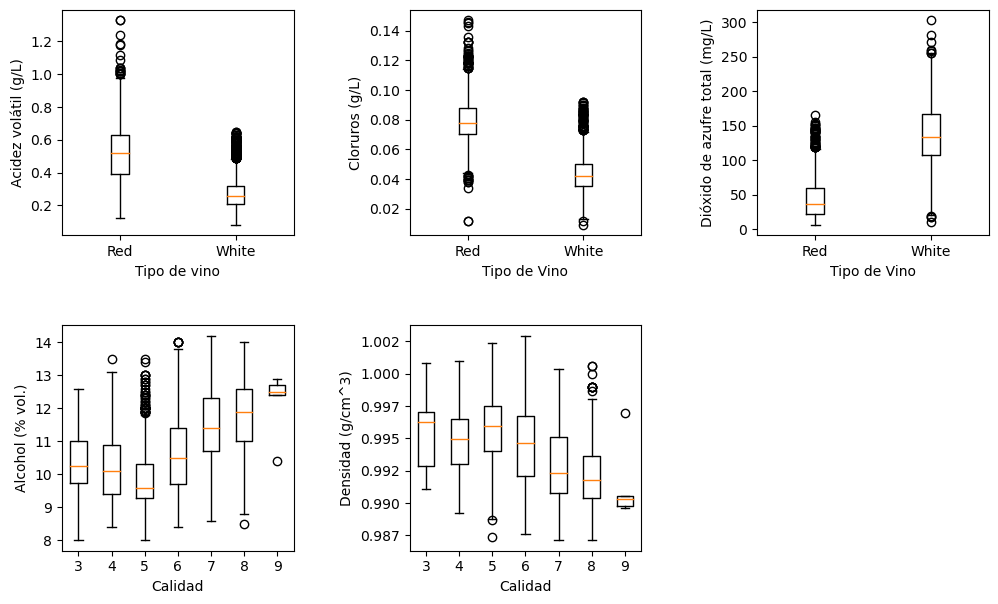

In [38]:
fig, pos = plt.subplots(2, 3, figsize=(10, 6))  # 2 filas y 3 columnas
fig.tight_layout()  # para separar los gráficos
fig.subplots_adjust(hspace=0.4, wspace = 0.5)  # aumentar el espacio entre filas y columnas

for i in range(len(xlabels)): # De manera que i es el indice y col_name valor de la lista
    # Usamos lógica modular para calcular el valor de las filas y las columnas  
    row_i = i // 3
    col_i = i % 3
    # Crear los diagramas de cajas
    indVar = independentVariable[i]
    depVar = dependentVariable[i]
    pos[row_i][col_i].boxplot(
        [dataWine[dataWine[indVar] == q][depVar] for q in sorted(dataWine[indVar].unique())],
        labels=sorted(dataWine[indVar].unique())
    )
    
    # Poner etiqueta del eje x
    pos[row_i][col_i].set_xlabel(xlabels[i])
    
    # Poner etiqueta del eje y
    pos[row_i][col_i].set_ylabel(ylabels[i])
    
        
    if ylabels[i] == "Densidad (g/cm^3)":
        # Configurar el formateador para mostrar 3 decimales
        pos[row_i][col_i].yaxis.set_major_formatter(formatter)
    
    
# Desactivar el subplot vacío en la posición [2][3]
pos[1][2].axis('off')

plt.show()

# (11)

**Nota: las preguntas se respondieron en el punto 11 por simplicidad.**

<u>Hipótesis: 

**Nula (H0)**: el promedio de la variable dependiente es igual para todos los grupos/categorias.

**Alternativa (H1)**: el promedio de la variable dependiente es diferente para al menos un grupo/categoria.

<u>Interpretación:
    
Se dice que se rechaza H0 si el *p-value* es menor al nivel de significancia (α). En este caso, se cuenta con evidencia que apoya que almenos una pareja de los grupos estudiados presente diferencias significativas entre los promedios de la variable dependiente. Para determinar cuáles grupos presentan diferencias significativas entre sus medias se debe realizar la prueba HSD de Tukey.

A partir de lo anterior, creamos una función que realice el ANOVA y la prueba de Tukey:

In [39]:
def computeAnova(dataFrame, independentVariable, dependentVariable, significance):
    """
    Función que se encarga de realizar un ANOVA de una vía según el dataframe y el nombre de la variable independiente
    recibida por argumentos.
    
    Args:
        dataFrame(pandas.DataFrame): dataframe que contiene el "set" de datos. 
        independentVariable(str): nombre de la columna que contiene la variable independiente (o categorias) que se usa 
                                  para computar el ANOVA.
        dependentVariable(str): nombre de la columna que contiene la variable dependiente que se usa determinar si hay 
                                diferencias significativas en sus medias.
        significance(int): nivel de significancia que se emplea para determinar si los grupos presentan diferencias significativas. 
    """
    categories = dataFrame[independentVariable].unique()
    date_per_category = [dataFrame[dataFrame[independentVariable] == category][dependentVariable] for category in categories]

    # ANOVA
    _, p_value = stats.f_oneway(*date_per_category)

    print(f"> p-Value: {p_value:}, Significance: {significance}\n") # Si el p-value es reportado como 0, es porque es muy bajo
    print(1.000000)
    # Determinar si hay diferencias significativas
    if (p_value < significance):
        print(f"> p-value < {significance}:")
        print(f"\tLas medias de las categorias almacenadas en {independentVariable} presenta diferencias significativas para la variable {dependentVariable}. \n") 
        print("> Prueba HSD Tukey:\n")
        # Si hay diferencias significativas, se realiza la prueba HSD de Tukey
        tukey = pairwise_tukeyhsd(endog = dataFrame[dependentVariable],
                          groups = dataFrame[independentVariable],
                          alpha = significance) # significancia
        print(tukey)
    else:
        print(f"p-value > {significance}:")
        print(f"\tLas medias de las categorias almacenadas en {independentVariable} no presentan diferencias significativas para la variable {dependentVariable}.")         

**¿Existen diferencias significativas entre las medias de los valores de `alcohol` para las diferentes calidades?:**

In [40]:
computeAnova(dataWineQuality4_8, "quality", "alcohol", 0.05) 
#Nota: p-value es igual a cero porque es muy bajo.

> p-Value: 0.0, Significance: 0.05

1.0
> p-value < 0.05:
	Las medias de las categorias almacenadas en quality presenta diferencias significativas para la variable alcohol. 

> Prueba HSD Tukey:

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     4      5  -0.3415 0.0002 -0.5583 -0.1247   True
     4      6   0.4155    0.0  0.2013  0.6297   True
     4      7   1.1992    0.0  0.9742  1.4242   True
     4      8   1.4774    0.0  1.1834  1.7714   True
     5      6    0.757    0.0  0.6725  0.8415   True
     5      7   1.5407    0.0  1.4317  1.6497   True
     5      8   1.8189    0.0  1.6005  2.0372   True
     6      7   0.7837    0.0  0.6799  0.8875   True
     6      8   1.0619    0.0   0.846  1.2777   True
     7      8   0.2782 0.0073  0.0516  0.5047   True
----------------------------------------------------


**¿Existen diferencias significativas entre las medias de los valores de `density` para las diferentes calidades?**

In [41]:
computeAnova(dataWineQuality4_8, "quality", "density", 0.05) 

> p-Value: 6.982855466300594e-167, Significance: 0.05

1.0
> p-value < 0.05:
	Las medias de las categorias almacenadas en quality presenta diferencias significativas para la variable density. 

> Prueba HSD Tukey:

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     4      5    0.001    0.0  0.0005  0.0016   True
     4      6  -0.0003 0.7345 -0.0008  0.0003  False
     4      7  -0.0017    0.0 -0.0023 -0.0011   True
     4      8  -0.0023    0.0 -0.0031 -0.0015   True
     5      6  -0.0013    0.0 -0.0015 -0.0011   True
     5      7  -0.0027    0.0  -0.003 -0.0025   True
     5      8  -0.0033    0.0 -0.0039 -0.0027   True
     6      7  -0.0015    0.0 -0.0017 -0.0012   True
     6      8   -0.002    0.0 -0.0026 -0.0015   True
     7      8  -0.0006 0.0643 -0.0012     0.0  False
----------------------------------------------------


**¿Existen diferencias significativas entre las medias de los valores de `volatile_acidity` para los tipos de vino?**:

In [42]:
computeAnova(dataWineQuality4_8, "wine_type", "volatile_acidity", 0.05) 

> p-Value: 0.0, Significance: 0.05

1.0
> p-value < 0.05:
	Las medias de las categorias almacenadas en wine_type presenta diferencias significativas para la variable volatile_acidity. 

> Prueba HSD Tukey:

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
   Red  White  -0.2509   0.0 -0.2578 -0.244   True
--------------------------------------------------


**¿Existen diferencias significativas entre las medias de los valores de `chlorides` para los tipos de vino?**:

In [43]:
computeAnova(dataWineQuality4_8, "wine_type", "chlorides", 0.05) 

> p-Value: 0.0, Significance: 0.05

1.0
> p-value < 0.05:
	Las medias de las categorias almacenadas en wine_type presenta diferencias significativas para la variable chlorides. 

> Prueba HSD Tukey:

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   Red  White  -0.0364   0.0 -0.0371 -0.0356   True
---------------------------------------------------


**¿Existen diferencias significativas entre las medias de los valores de `total_SO2` para los tipos de vino?**:

In [44]:
computeAnova(dataWineQuality4_8, "wine_type", "total_SO2", 0.05) 

> p-Value: 0.0, Significance: 0.05

1.0
> p-value < 0.05:
	Las medias de las categorias almacenadas en wine_type presenta diferencias significativas para la variable total_SO2. 

> Prueba HSD Tukey:

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   Red  White  92.8796   0.0 90.5541 95.2052   True
---------------------------------------------------
